In [1]:
import datetime
import pandas as pd
from pymongo import MongoClient
from zeep import Client
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

**1). Запросить курсы любой валюты за указанный период. Сохранить полученные данные в базу данных Mongo**

**2). Написать функцию, которая принимает в качестве параметров две даты, ищет самую большую разницу между курсами валюты за указанный период и возвращает эти дни.**

**3). Сделать вывод информативным: Валюту <Валюта> выгодно было купить <Дата>, а продать <Дата>. Прибыль: <Разница в цене валюты>**

In [2]:
wsdl = 'http://www.cbr.ru/DailyInfoWebServ/DailyInfo.asmx?WSDL'
zeep_client = Client(wsdl)

In [3]:
currency_name = 'Австралийский доллар'

In [4]:
currencies = zeep_client.service.EnumValutes(Seld=False)

In [5]:
for currency in currencies._value_1._value_1:
    for _, currency_info in currency.items():
        if currency_name in currency_info['Vname']:
            currency_code = currency_info['Vcode']

In [6]:
from_date = datetime.date(2018, 9, 15) # datetime.date(2018, 5, 10)
to_date = datetime.date(2018, 9, 20) # datetime.date(2019, 8, 15)

In [7]:
dynamics = zeep_client.service.GetCursDynamic(from_date, to_date, currency_code)

In [8]:
df = pd.DataFrame(columns=['date', 'rate'])

for date in dynamics._value_1._value_1:
    for _, date_info in date.items():
        rate_info = {'date': date_info['CursDate'],
                     'rate': date_info['Vcurs']}
        df = df.append(rate_info, ignore_index=True)

In [9]:
df['date'] = pd.to_datetime(df['date'], utc=True)
df['rate'] = df['rate'].astype(float)

df.set_index('date', inplace=True)

Поиск самой выгодной разницы курса:
    - проходим по всем датам (это индекс i);
    - ищем максимальный пик курса в будущем (rate_peak)
    - считаем разницу между между rate_peak и текущим курсом (rate_now).
Нам нужно найти и зафиксровать самую большую положительную разницу - как искомую выгоду.

In [10]:
income, max_income = 0., 0.
for i in df.index:
    rate_now = df['rate'].loc[i]
    
    mask = df.index >= i
    rate_peak = df.loc[mask, 'rate'].max()
 
    income = rate_peak - rate_now
    if income > max_income:
        max_income = income
        rate_min = rate_now
        rate_idxmin = i
        rate_max = rate_peak
        rate_idxmax = df.loc[mask, 'rate'].idxmax()
        break
        
if max_income == 0.:
    rate_idxmin, rate_idxmax = i, i
    rate_min = rate_now
    rate_max = rate_now

In [11]:
def date2str(date):
    return '{}.{}.{}'.format(date.day, date.month, date.year)

In [12]:
from_date_str = date2str(from_date)
to_date_str = date2str(to_date)

date_min = date2str(rate_idxmin)
date_max = date2str(rate_idxmax)

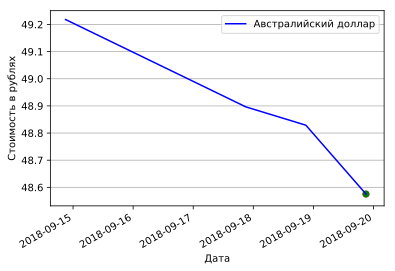

Австралийский доллар c 15.9.2018 по 20.9.2018 продавать было невыгодно.


In [13]:
df['rate'].plot(c='b', label=currency_name)
plt.scatter(rate_idxmin, rate_min, c='r')
plt.scatter(rate_idxmax, rate_max, c='g')
plt.xlabel('Дата')
plt.ylabel('Стоимость в рублях')
plt.grid(axis='y')
plt.legend(loc='best')
plt.show()

if max_income > 0.:
    print('{} выгодно было купить {}, а продать {}.\nПрибыль: {:.2} руб.'.format( \
          currency_name, date_min, date_max, rate_max - rate_min))
else:
    print('{} c {} по {} продавать было невыгодно.'.format( \
          currency_name, from_date_str, to_date_str))    

Добавляем данные в БД:

In [14]:
mongo_client = MongoClient('mongodb://127.0.0.1:27017')

In [15]:
db = mongo_client['rates']
docs = db.docs

In [16]:
db_info = {'from_date': from_date_str,
           'to_date': to_date_str,
           'rate': list(df['rate'])}

In [17]:
is_rate_in = docs.find_one({"from_date": from_date_str,
                            "to_date": to_date_str})
if is_rate_in == None:
    result = docs.insert_one(db_info)

Проверка:

In [18]:
results = docs.find({"from_date": from_date_str,
                     "to_date": to_date_str})
for r in results:
    print(r)

{'_id': ObjectId('5d6025183953933652ad0c0f'), 'from_date': '15.9.2018', 'to_date': '20.9.2018', 'rate': [49.2181, 48.8964, 48.8288, 48.5754]}


In [19]:
# mongo_client.drop_database('rates')